In [2]:
print ("Hello Jupyter")

Hello Jupyter


In [5]:
#Zip Datei entpacken
import numpy as np
import zipfile
import os
import tifffile
import glob

# Pfad zu deiner ZIP-Datei
zip_path = "C:/Users/hendr/Desktop/ML_Seminar/MoNuSAC_images_and_annotations.zip"
#extract_dir = "C:/Users/hendr/Desktop/ML_Seminar\data"
extract_dir = "C:/Users/hendr/Desktop/ML_Seminar\data"
extract_dir2  = "C:/Users/hendr/Desktop/ML_Seminar\MoNuSAC_masks" #load masks instead of datasets

# Ordner erstellen, falls nicht vorhanden
#os.makedirs(extract_dir, exist_ok=True)

# ZIP entpacken
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_dir)

#print("Fertig! Dateien entpackt nach:", extract_dir)

tif_files = glob.glob(os.path.join(extract_dir,"**", "*.tif"), recursive=True)
print(f"Gefundene TIFF-Dateien: {len(tif_files)}")

# Alle .tif-Dateien im Ordner
tif_files2 = glob.glob(os.path.join(extract_dir2,"**", "*.tif"), recursive=True)
print(f"Gefundene TIFF-Dateien: {len(tif_files2)}")
#print(tif_files2[:5])  # die ersten 5 anzeigen

Gefundene TIFF-Dateien: 209
Gefundene TIFF-Dateien: 394


Alle Bilder geladen: 209


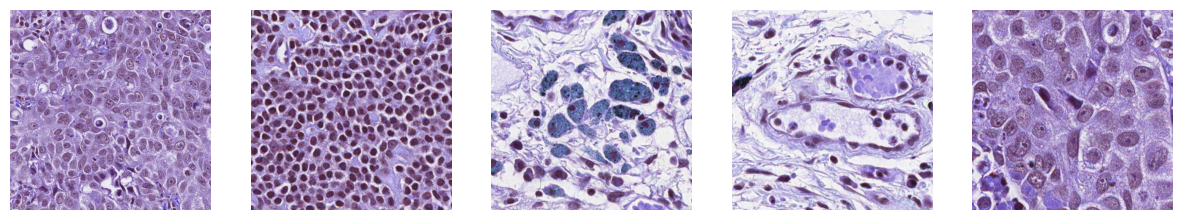

In [6]:
import matplotlib.pyplot as plt

images_original = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_original.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Alle Bilder geladen:", len(images_original))

if len(images_original) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_original))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_original[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

Alle Bilder geladen: 394


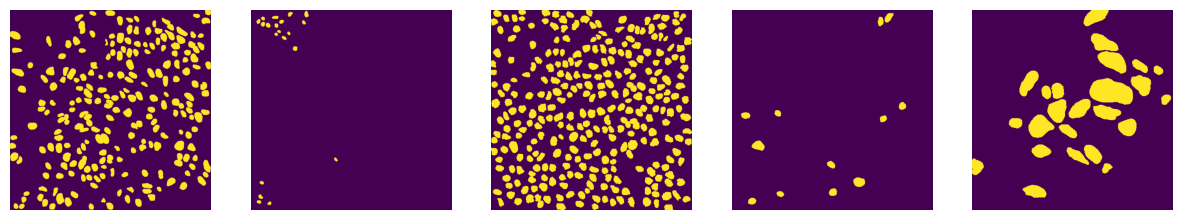

In [7]:
images_masks = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files2 if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_masks.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Alle Bilder geladen:", len(images_masks))

if len(images_masks) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_masks))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_masks[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

In [11]:
import os
import glob
import numpy as np
import tifffile
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models


# --- KONFIGURATION ---
IMG_SIZE = 256  # Wir verkleinern die Bilder auf 256x256 für das Training
N_CLASSES = 5 # Hintergrund + 4 Zelltypen
extract_dir = "C:/Users/hendr/Desktop/ML_Seminar/data"           # Originalbilder
extract_dir2 = "C:/Users/hendr/Desktop/ML_Seminar/MoNuSAC_masks" # Masken

class_map = {
    "Epithelial": 1,
    "Lymphocyte": 2,
    "Neutrophil": 3,
    "Macrophage": 4
}

# --- SCHRITT 1: DATEIEN FINDEN ---
# Alle Originalbilder finden
original_files = glob.glob(os.path.join(extract_dir, "**", "*.tif"), recursive=True)
# Alle Masken finden
mask_files_all = glob.glob(os.path.join(extract_dir2, "**", "*.tif"), recursive=True)

print(f"Originalbilder gefunden: {len(original_files)}")
print(f"Masken gefunden (gesamt): {len(mask_files_all)}")

# --- SCHRITT 2: BILDER UND MASKEN MATCHEN UND LADEN ---
X_data = [] # Input Bilder
Y_data = [] # Output Masken

# Daten verarbeitung, Bilder matchen
for img_path in original_files:
    try:
        # --- A. Originalbild laden ---
        img = tifffile.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0 # Normalisieren
        
        # --- B. Masken suchen ---
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        current_mask_paths = [m for m in mask_files_all if base_name in m]
        
        if len(current_mask_paths) == 0: continue

        # --- C. Multi-Class Maske erstellen ---
        # Wir erstellen einen leeren Würfel: (256, 256, 5)
        # Am Anfang ist alles "Hintergrund" (Klasse 0)
        # Wir nutzen hier 'argmax' Logik vorbereitend: Ein 2D Array mit Werten 0-4
        mask_2d = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        
        for m_path in current_mask_paths:
            # Maske laden
            m = tifffile.imread(m_path)
            m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            # Herausfinden, welche Klasse das ist
            class_id = 0
            for class_name, cid in class_map.items():
                if class_name in m_path: # Z.B. wenn "Epithelial" im Pfad steht
                    class_id = cid
                    break
            
            if class_id > 0:
                # Setze die Pixel an der Stelle auf die Klassen-ID (z.B. 2)
                # np.where(bedingung, neuer_wert, alter_wert)
                mask_2d = np.where(m > 0, class_id, mask_2d)

        # One-Hot Encoding für Keras: Aus (256,256) mach (256,256,5)
        # Das wandelt die 0,1,2,3,4 in Vektoren um [1,0,0,0,0], [0,1,0,0,0] etc.
        mask_onehot = tf.keras.utils.to_categorical(mask_2d, num_classes=N_CLASSES)

        X_data.append(img)
        Y_data.append(mask_onehot)
        
    except Exception as e:
        print(f"Fehler bei {img_path}: {e}")

X = np.array(X_data)
Y = np.array(Y_data)

print(f"Fertig! Datensätze erstellt.")
print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}") # Sollte (Anzahl, 256, 256, 5) sein

# --- SCHRITT 3: TRAIN / VAL SPLIT ---
# Wir splitten erst JETZT, damit Input und Output zusammenbleiben
# Split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- 3. U-NET MODELL (MULTI-CLASS UPDATE) ---
def multiclass_unet(input_size=(256, 256, 3), num_classes=5):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c5)
    
    # OUTPUT LAYER WICHTIG:
    # Anzahl Filter = Anzahl Klassen (5)
    # Aktivierung = 'softmax' (Damit sich die Wahrscheinlichkeiten auf 100% summieren)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = multiclass_unet(num_classes=N_CLASSES)

# WICHTIG: Loss Function ändern!
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Originalbilder gefunden: 209
Masken gefunden (gesamt): 394
Fertig! Datensätze erstellt.
X Shape: (209, 256, 256, 4)
Y Shape: (209, 256, 256, 5)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# --- SCHRITT 5: TRAINING ---
# 1. Stoppt das Training, wenn der "val_loss" sich 10 Epochen lang nicht verbessert
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,            # Wie viele Epochen warten wir auf Besserung?
    restore_best_weights=True, # Am Ende das beste Modell wiederherstellen (WICHTIG!)
    verbose=1
)

# Optional: Reduziert die Lernrate, wenn es stagniert (Feintuning)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001,
    verbose=1
)

print("Starte Training...")
X_train = X_train[..., :3] #löschen den alpha kanal
X_val = X_val[..., :3] #löschen den alpha kanal
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=8, 
    epochs=100,  # number der epochen
    callbacks=[early_stopping, reduce_lr]
)

Starte Training...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.8716 - loss: 0.3474 - val_accuracy: 0.8684 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.8711 - loss: 0.3587 - val_accuracy: 0.8716 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.8701 - loss: 0.3586 - val_accuracy: 0.8665 - val_loss: 0.3612 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.8684 - loss: 0.3576 - val_accuracy: 0.8730 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.8713 - loss: 0.3600 - val_accuracy: 0.8766 - val_loss: 0.3346 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.8733 - loss: 0.3516 - val_accuracy: 0.8685 - val_loss: 0.3638 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy

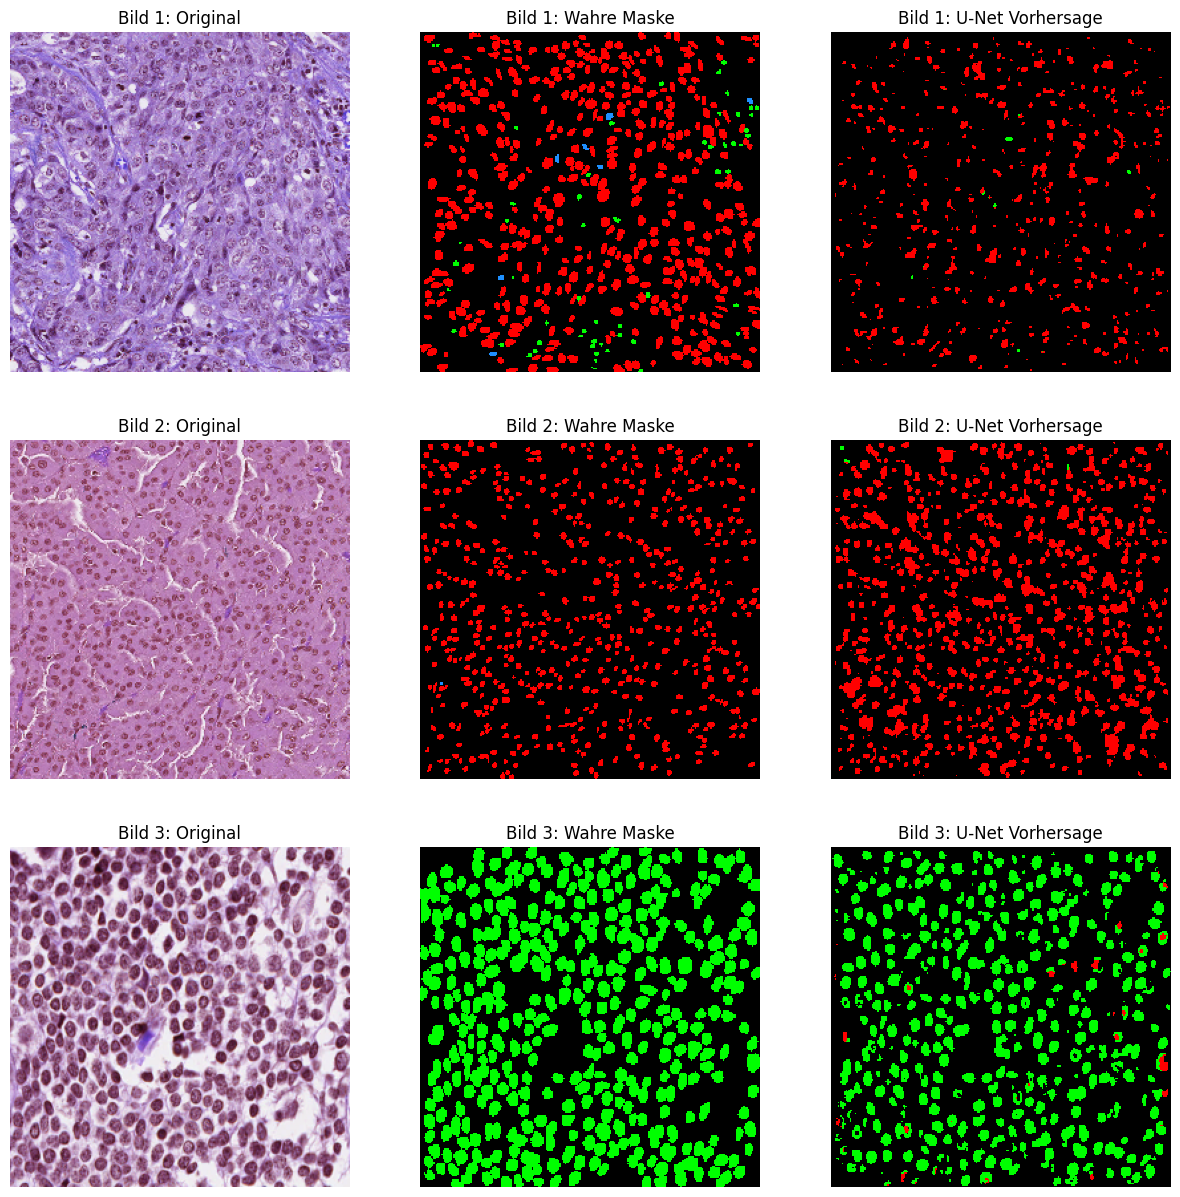

In [14]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# --- 1. FARBEN & KLASSEN DEFINIEREN ---
class_definitions = {
    0: {"name": "Hintergrund", "color": "black"},
    1: {"name": "Epithelial",  "color": "red"},
    2: {"name": "Lymphocyte",  "color": "lime"}, 
    3: {"name": "Neutrophil",  "color": "dodgerblue"}, # Helleres Blau für besseren Kontrast
    4: {"name": "Macrophage",  "color": "yellow"}
}

colors = [class_definitions[i]["color"] for i in range(len(class_definitions))]
cmap = ListedColormap(colors)

# --- 2. VORHERSAGE & PLOTTING ---
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

# Falls nur 1 Sample da ist, sicherstellen, dass axes ein 2D-Array ist
if num_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(num_samples):
    # Vorhersage
    input_img = X_val[i:i+1]
    pred_onehot = model.predict(input_img, verbose=0)
    pred_mask = np.argmax(pred_onehot[0], axis=-1)
    true_mask = np.argmax(y_val[i], axis=-1)
    
    # Spalte 1: Original
    axes[i, 0].imshow(X_val[i])
    axes[i, 0].set_title(f"Bild {i+1}: Original")
    axes[i, 0].axis("off")
    
    # Spalte 2: Wahre Maske
    axes[i, 1].imshow(true_mask, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')
    axes[i, 1].set_title(f"Bild {i+1}: Wahre Maske")
    axes[i, 1].axis("off")
    
    # Spalte 3: Vorhersage
    im = axes[i, 2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')
    axes[i, 2].set_title(f"Bild {i+1}: U-Net Vorhersage")
    axes[i, 2].axis("off")